# Simple Classifier / Logistic Regression

After having worked with the dataloading part last week, we want to start this week with a more detailed look into how the training process works. So far, our tools are limited and we must restrict ourselves to a simplified model. But nevertheless, this gives us the opportunity to look at the different parts of the training process in more detail and builds up a good base for when we turn to more complicated model architectures in the next exercises.

This notebook will demonstrate a simple logistic regression model predicting whaether a house is ```low-priced``` or ```expensive```. The data that we will use here is the HousingPrice dataset. Feeding some features in our classifier, the output should then be a score that determines in which category the considered house is.

<img name="classifierTeaser" src="https://drive.google.com/uc?id=1QX7hqHIjq0FF-bTfoZc_y9gZptdsm2nm">

Before we start, let us first import some libraries and code that we will need along the way.

## (Optional) Mount folder in Colab

Uncomment thefollowing cell to mount your gdrive if you are using the notebook in google colab:

In [ ]:
# Use the following lines if you want to use Google Colab
# We presume you created a folder "i2dl" within your main drive folder, and put the exercise there.
# NOTE 1: terminate all other colab sessions that use GPU!
# NOTE 2: Make sure the correct exercise folder (e.g exercise_04) is given.


from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/Colab Notebooks/i2dl/exercise_04'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))


Mounted at /content/gdrive
['.empty', '1_simple_classifier.ipynb', '__init__.py', 'create_submission.sh', 'exercise_code', 'housing_data_preprocessing(optional).ipynb', 'images']


In [ ]:
from exercise_code.data.csv_dataset import CSVDataset
from exercise_code.data.csv_dataset import FeatureSelectorAndNormalizationTransform
from exercise_code.data.dataloader import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns


pd.options.mode.chained_assignment = None  # default='warn'

%load_ext autoreload
%autoreload 2
%matplotlib inline

os.environ['KMP_DUPLICATE_LIB_OK']='True' # To prevent the kernel from dying.

## 0. Dataloading and Data Preprocessing

Let us load the data that we want to use for our training. The method `get_housing_data()` is providing you with a training, validation and test set that is ready to use.

For more information about how to prepare the data and what the final data look like, you can have a look at the notebook `housing_data_preprocessing(optional).ipynb `. We reduced our data and the remaining houses in our dataset are now either labeled with ```1``` and hence categorized as ```expensive```, or they are labeled with ```0``` and hence categorized as ```low-priced```.


In [ ]:
from exercise_code.networks.utils import *

X_train, y_train, X_val, y_val, X_test, y_test, train_dataset = get_housing_data()

print("train data shape:", X_train.shape)
print("train targets shape:", y_train.shape)
print("val data shape:", X_val.shape)
print("val targets shape:", y_val.shape)
print("test data shape:", X_test.shape)
print("test targets shape:", y_test.shape, '\n')

print('The original dataset looks as follows:')
train_dataset.df.head()

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


You successfully loaded your data! 

train data shape: (533, 1)
train targets shape: (533, 1)
val data shape: (167, 1)
val targets shape: (167, 1)
test data shape: (177, 1)
test targets shape: (177, 1) 

The original dataset looks as follows:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
529,530,20,RL,NaN,32668,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Alloca,200624
491,492,50,RL,79.0,9490,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,8,2006,WD,Normal,133000
459,460,50,RL,NaN,7015,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,7,2009,WD,Normal,110000
279,280,60,RL,83.0,10005,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2008,WD,Normal,192000
655,656,160,RM,21.0,1680,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2010,WD,Family,88000


The data is now ready and can be used to train our classifier model.

## 1. Set up a Classifier Model

Let $\mathbf{X} \in \mathbb{R}^{N\times (D+1)}$ be our data with $N$ samples and $D$ feature dimensions (+1 for the bias). With our classifier model, we want to predict binary labels $\mathbf{\hat{y}} \in \mathbb{R}^{N\times 1}$. Our classifier model should be of the form

$$ \mathbf{\hat{y}}  = \sigma \left( \mathbf{X} \cdot \mathbf{w} \right), $$

$ $ where $\mathbf{w}\in \mathbb{R}^{(D+1) \times 1}$ is the weight matrix of our model.

The **sigmoid function** $\sigma: \mathbb{R} \to [0, 1]$, defined by

$$ \sigma(t) = \frac{1}{1+e^{-t}} $$

is used to squash the outputs of the linear layer into the interval $[0, 1]$. The layer is saturated, when the output approaches its upper or lower boundaries. Remember that the sigmoid function is a real-valued function. When applying it on a vector, the sigmoid is operating component-wise.

The output of the sigmoid function can be seen as the probability that our sample is indicating a house that can be categorized as ```expensive```. As the probability gets closer to 1, our model is more confident that the input sample is in the class ```expensive```.

<img src="https://miro.medium.com/max/2400/1*RqXFpiNGwdiKBWyLJc_E7g.png" width="800">

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>Take a look at the implementation of the <code>Classifier</code> class in <code>exercise_code/networks/classifier.py</code>. To create a <code>Classifier</code> object, you need to define the number of features that our classifier model takes as input.</p>
</div>

## 2. Loss: Binary Cross Entropy

For a binary classification like our task, we use a loss function called Binary Cross-Entropy (BCE).

$$BCE(y,\hat{y}) =- \frac{1}{N} \sum_{i = 1}^N \left[y_i \cdot log(\hat y_i ) + (1- y_i) \cdot log(1-\hat y_i)\right]$$

where $y\in\mathbb{R}$ is the ground truths vector, $\hat y\in\mathbb{R}$ is the vector of predicted probabilities of the houses being expensive and $N$ is the number of samples.

In constrast to linear-regression, for the BCE there is no closed-form solution for the optimal weights vector. In order to find the optimal parameters for our model, we need to use numeric methods such as **Gradient Descent**. But let us have a look at that later. First, you have to complete your first task:

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>In <code>exercise_code/networks/loss.py</code> complete the implementation of the BCE loss function. You need to write the forward and backward pass of BCE as <code>forward()</code> and <code>backward()</code> function. The backward pass of the loss is needed to later optimize your weights of the model. You can test your implementation by executing the included testing code in the cell below.</p>
    <p>Note: Both functions must be implemented for the backward test to pass! </p>
</div>

In [ ]:
from exercise_code.tests.loss_tests import *
from exercise_code.networks.loss import BCE

bce_loss = BCE()
res = test_bce(bce_loss)


####### Testing BCETest Started #######

Test BCEForwardTest: passed!
Test BCEBackwardTestNormal: passed!

####### Testing BCETest Finished #######
Test BCETest: passed! -->  Tests passed: 2/2
Score: 100/100


## 3. Backpropagation

The backpropagation algorithm allows the information from the loss flowing backward through the network in order to compute the gradient of the loss function $L$ w.r.t the weights $w$ of the model and the layers' inputs $x$.

The key idea of backpropagation is decomposing the derivatives by applying the chain rule to the loss function.

$$ \frac{\partial L}{\partial w} = \frac{\partial L}{\partial \hat y} \cdot \frac{\partial \hat y}{\partial w}$$

You have already completed the `forward()` and `backward()` pass of the loss function, which can be used to compute the derivative  $\frac{\partial L}{\partial \hat y}$. In order to compute the second term $\frac{\partial \hat y}{\partial w}$, we need to implement a similar `forward()` and `backward()` method in our `Classifier` class.

### Backward Pass

The backward pass consists of computing the derivative $\frac{\partial \hat y}{\partial w}$. Again, we can decompose this derivative by the chain rule: For $s = X \cdot w$ we obtain

$$\frac{\partial \hat y}{\partial w} = \frac{\partial \sigma(s)}{\partial w} = \frac{\partial \sigma(s)}{\partial s} \cdot \frac{\partial s}{\partial w}$$


**Hint:** Taking track of the dimensions in higher-dimensional settings can make the task a little bit complicated. Make sure you understand the operations here. If you have difficulties, then first try to understand the forward and backward pass with a single input consisting of $D+1$ features. In that case our data matrix has the dimension $X \in \mathbb{R}^{1 \times (D+1)}$. After you have understood this situation, you can go back to the setting where our data matrix has dimension $X \in \mathbb{R}^{N \times (D+1)}$ and consists of $N$ samples each having $D+1$ features.

**Hint 2**: It is helpful to follow the [TUM article][] (Section 3) calculating the chain-rule, while dealing with matrix notations:

**Note**: If $X$ is of shape $N\times D$, then in this exercise it is $N\times (D+1)$, as we concatanate the affine layer's bias term to it, instead of having a different variable.

[TUM article]: https://bit.ly/tum-article "Article"

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Implement the <code>forward()</code> and <code>backward()</code> pass as well as the <code>sigmoid()</code> function in the <code>Classifier</code> class in <code>exercise_code/networks/classifier.py</code>. Check your implementation using the following testing code.</p>
</div>

In [ ]:
from exercise_code.networks.classifier import Classifier
from exercise_code.tests.classifier_test import *
res = test_classifier(Classifier())


####### Testing ClassifierTest Started #######


####### Testing SigmoidMethodTest Started #######

Test Sigmoid_Of_Zero: passed!
Test Sigmoid_Of_Zero_Array: passed!
Test Sigmoid_Of_100: passed!
Test Sigmoid_Of_Array_of_100: passed!

####### Testing SigmoidMethodTest Finished #######
Method sigmoid(): passed! -->  Tests passed: 4/4

####### Testing ForwardMethodTest Started #######

Test ClassifierForwardTest: passed!

####### Testing ForwardMethodTest Finished #######
Method forward(): passed! -->  Tests passed: 1/1

####### Testing BackwardMethodTest Started #######

Test ClassifierBackwardTest: passed!

####### Testing BackwardMethodTest Finished #######
Method backward(): passed! -->  Tests passed: 1/1

####### Testing ClassifierTest Finished #######
Test ClassifierTest: passed! -->  Tests passed: 6/6
Score: 100/100


## 4. Optimizer and Gradient Descent

Previously, we have successfully dealt with the loss function, which is a method of measuring how well our model fits the given data. The idea of the training process is to iteratively adjust the weights of our model in order to minimize the loss function.

And this is where the optimizer comes steps in. During each training step, the optimizer updates the weights of the model w.r.t. the output of the loss function, thereby linking the loss function and model parameters together. The goal is to obtain a model which is accurately predicting the class for a new sample.


Any discussion about optimizers needs to begin with the most popular one, and it's called Gradient Descent. This algorithm is used across all types of Machine Learning (and other math problems) to optimize. It's fast, robust, and flexible. Here's how it works:


0. Initialize the weights with random values.
1. Run the forward pass and calculate the loss with the current weights and the loss function.
2. Calculate the gradient of the loss function w.r.t. the weights.
3. Update weights with the corresponding gradient.
4. Iteratively perform Step 1 to 3 until converges.

The name of the optimizer already hints at the required concept: We use gradients which are very useful for minimizing a function. The gradient of the loss function w.r.t to the weights $w$ of our model tells us how to change our weights $w$ in order to minimize our loss function.

The weights are updated each step as follows:
$$ w_{(n+1)} = w_{(n)} - \alpha \cdot \frac {dL}{dw_{(n)}}, $$
where $ \frac {dL}{dw_{(n)}}$ is the gradient of your loss function w.r.t. the weights $w$ at the $n$-th optimization step and $\alpha$ is the learning rate, which is a predefined positive scalar (usually $ 0 < \alpha < 1 $) determining the size of the step.

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>In our model, we will use gradient descent to update the weights. Take a look at the <code>Optimizer</code> class in the file <code>networks/optimizer.py</code>. Your task is now to implement the gradient descent step in the <code>step()</code> method. You can test your implementation by the following testing code.</p>
</div>

In [ ]:
from exercise_code.networks.optimizer import Optimizer
from exercise_code.networks.classifier import Classifier
from exercise_code.tests.optimizer_test import *
TestClassifier=Classifier()
TestClassifier.initialize_weights()
res = test_optimizer(Optimizer(TestClassifier))


####### Testing OptimizerTest Started #######

Test OptimizerStepTest: passed!

####### Testing OptimizerTest Finished #######
Test OptimizerTest: passed! -->  Tests passed: 1/1
Score: 100/100


## 5. Training

We have now implemented all the necessary parts of our training process, namely:
- **Classifier Model:** We set up a simple classifier model and you implemented the corresponding ```forward()``` and ```backward()``` methods.
- **Loss function:** We chose the Binary Cross Entropy Loss for our model to measure the distance between the prediction of our model and the ground-truth labels. You implemented a forward and backward pass for the loss function.
- **Optimizer**: We use the Gradient Descent method to update the weights of our model. Here, you implemented the ```step()``` function which performs the update of the weights.

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>Before we start our training and put all the parts together, let us shortly talk about the weight initialization. In <code>networks/classifier.py</code> you can check the <code>Classifier</code> class. It contains a method called <code>initialize_weights()</code> that randomly initializes the weights of our classifier model. Later in the lecture, we will learn about more efficient methods to initialize the weights. But for now, a random initialization as it happens in the <code>initialize_weights()</code> method is sufficient.</p>
</div>

Let's start with our classifier model and look at its performance before any training happened.

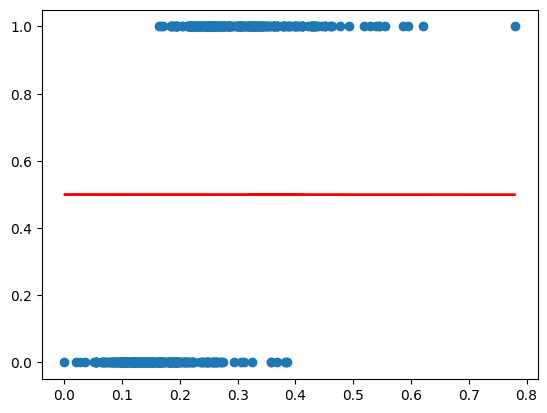

In [ ]:
from exercise_code.networks.classifier import Classifier

#initialization
model = Classifier(num_features=1)
model.initialize_weights()

y_out = model.forward(X_train)

# plot the prediction
plt.scatter(X_train, y_train)
plot = plt.plot(X_train, y_out, color='r')


As you can see the predictions of our model without any training are very bad. Let's see how the performance improves when we start our training, which means that we update our weights by applying the gradient descent method. The following cell combines the forward and backward passes with the gradient update step and performs a training step for our classifier:

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>Note that the <code>Classifier</code> class is derived from the more general <code>Network</code> class. It is worth having a look at the basis class <code>Network</code> in the file <code>exercise_code/networks/base_networks.py</code>. We will make use of the <code>__call__()</code> method, which computes the forward and backward pass of your classifier. In a similar manner, we use the <code>__call__()</code> function for our Loss function.</p>
</div>

The following cell performs training with 400 training steps:

In [ ]:
from exercise_code.networks.optimizer import *
from exercise_code.networks.classifier import *
from exercise_code.tests.base_tests import bcolors

# Hyperparameter Setting. We will specify the loss function we use, and implement the optimizer we finished in the last step.
num_features = X_train.shape[1]

# initialization
model = Classifier(num_features=num_features)
model.initialize_weights()

loss_func = BCE()
learning_rate = 5e-1  # A hyperparameter
loss_history = []
optimizer = Optimizer(model, learning_rate)

epochs = 400 # A hyperparameter
print_every = 10 # A hyperparameter

best_loss = np.inf
# Full batch Gradient Descent
for i in range(epochs):

    # Enable your model to store the gradient.
    model.train()
    # Compute the output and gradients w.r.t weights of your model for the input dataset.
    model_forward = model.forward(X_train)

    # Compute the loss and gradients w.r.t output of the model. The begining of the chain rule.
    loss = loss_func(model_forward, y_train)
    loss_grad = loss_func.backward(model_forward, y_train)

    # Send the upstream derivative to continue the chain rule.
    grad = model.backward(loss_grad)

    optimizer.step(grad)

    # Average over the loss of the entire dataset and store it.
    average_loss = np.mean(loss)
    loss_history.append(average_loss)
    if i % print_every == 0:
        if average_loss < best_loss:
            best_loss = average_loss
            average_loss = bcolors.colorize("green", average_loss)
        else:
            average_loss = bcolors.colorize("red", average_loss)
        print("Epoch ",i,"--- Average Loss: ", average_loss)

model.eval() # Change the node of the network to evaluation mode!
model_forward = model(X_test)

accuracy = test_accuracy(model_forward, y_test)
print("\nEvaluate the trained model on the X_test set: ")
print("Accuracy: {:.1f}%".format(accuracy*100))


Epoch  0 --- Average Loss:  0.6931921658980231
Epoch  10 --- Average Loss:  0.6858005116820843
Epoch  20 --- Average Loss:  0.6786849875807074
Epoch  30 --- Average Loss:  0.6717786055755216
Epoch  40 --- Average Loss:  0.6650714296688355
Epoch  50 --- Average Loss:  0.6585569703203596
Epoch  60 --- Average Loss:  0.6522290279299132
Epoch  70 --- Average Loss:  0.6460815213733008
Epoch  80 --- Average Loss:  0.6401084909682478
Epoch  90 --- Average Loss:  0.6343041096151655
Epoch  100 --- Average Loss:  0.6286626924141591
Epoch  110 --- Average Loss:  0.6231787043176649
Epoch  120 --- Average Loss:  0.6178467659343339
Epoch  130 --- Average Loss:  0.6126616576446267
Epoch  140 --- Average Loss:  0.6076183221992916
Epoch  150 --- Average Loss:  0.6027118659749793
Epoch  160 --- Average Loss:  0.5979375590587165
Epoch  170 --- Average Loss:  0.5932908343260199
Epoch  180 --- Average Loss:  0.5887672856673062
Epoch  190 --- Average Loss:  0.5843626655050509
Epoch  200 --- Average Loss:  0

We can see that our average loss is decreasing as expected. Let us visualize the average loss and the prediction after our short training:

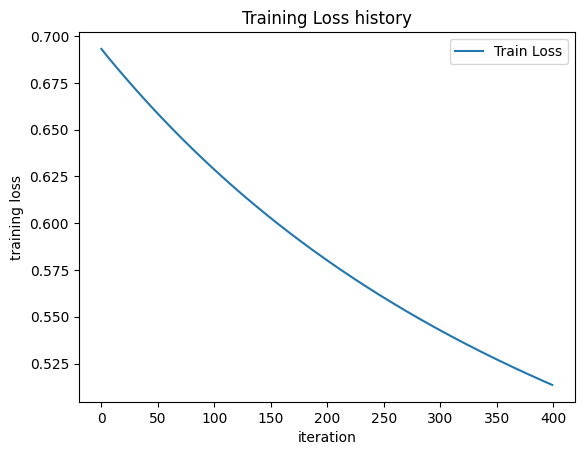

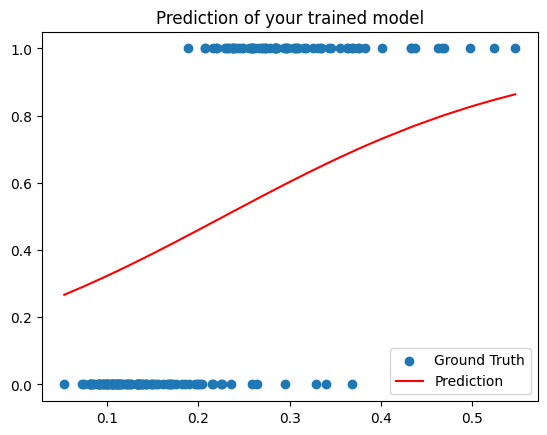

In [ ]:
# Plot the loss history to see how it goes after several steps of gradient descent.
plt.plot(loss_history, label = 'Train Loss')
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.legend()
plt.show()

# forward pass
y_out = model(X_test)

# plot the prediction
plt.scatter(X_test, y_test, label = "Ground Truth")
inds = X_test.argsort(0).flatten()
plt.plot(X_test[inds], y_out[inds], color='r', label = "Prediction")
plt.legend()
plt.title('Prediction of your trained model')
plt.show()


This looks pretty good already and our model gets better in explaining the underlying relationship of data.

NOTE: Although the testing score is high, the above prediction graph is still somewhat of a poor performance. That is due to the threshold (Look at the implementation of the test_accuracy() function), which classifies the results, or "logits", to the binary classes. If the threshold value is $t \in \mathbb{R}$, then for $1 \leq i \leq N$, we have  
$$ g(x_i) = \begin{cases}
    1,& \text{if }\, \hat y_i > t \\
    0,              & \text{otherwise}
\end{cases}$$

Where $g(x)$ is the classifier function.

## 6. Solver

Now we want to put everything we have learned so far together in an organized and concise way, that provides easy access to train a network/model in your own script/code. The purpose of a solver is mainly to provide an abstraction for all the gritty details behind training your parameters, such as logging your progress, optimizing your model, and handling your data.

This part of the exercise will require you to complete the missing code in the ```Solver``` class and to train your model end to end.


<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Open the file <code>exercise_code/solver.py</code> and have a look at the <code>Solver</code> class. The <code>_step()</code> function is representing one single training step. So when using the Gradient Descent method, it represents one single update step using the Gradient Descent method. Your task is now to finalize this <code>_step()</code> function. You can test your implementation with the testing code included in the following cell.</p>
    <p> <b>Hint</b>: The implementation of the <code>_step()</code> function is very similar to the implementation of a training step as we observed above. You may have a look at that part first. </p>
</div>

In [63]:
from exercise_code.solver import Solver
from exercise_code.networks.classifier import Classifier
from exercise_code.tests.solver_tests import *
weights = np.array([[0.1],[0.1]])
TestClassifier = Classifier(num_features=1)
TestClassifier.initialize_weights(weights)
learning_rate = 5e-1
data = {'X_train': X_train, 'y_train': y_train,
        'X_val': X_val, 'y_val': y_val}
loss = BCE()
solver = Solver(TestClassifier, data, loss,learning_rate,verbose=True)

res = test_solver(solver)


####### Testing SolverTest Started #######

Test SolverStepTest: passed!

####### Testing SolverTest Finished #######
Method _step(): passed! -->  Tests passed: 1/1
Score: 100/100


After having successfully implemented the `step()` function in the `Optimizer` class, let us now train our classifier. We train our model with a learning rate $ \lambda = 0.1$ and with 25000 epochs. Your model should reach an accuracy which is higher than 85%.

In [ ]:
from exercise_code.solver import Solver
from exercise_code.networks.utils import test_accuracy
from exercise_code.networks.classifier import Classifier
# Select the number of features, you want your task to train on.
num_features = X_train.shape[1]
print("Number of features: ", num_features)

# initialize model and weights
model = Classifier(num_features=num_features)
model.initialize_weights()

y_out = model(X_test)

accuracy = test_accuracy(y_out, y_test)
print("Accuracy BEFORE training {:.1f}%".format(accuracy*100))


if np.shape(X_test)[1]==1:
    plt.scatter(X_test, y_test, label = "Ground Truth")
    inds = X_test.flatten().argsort(0)
    plt.plot(X_test[inds], y_out[inds], color='r', label = "Prediction")
    plt.legend()
    plt.show()

data = {'X_train': X_train, 'y_train': y_train,
        'X_val': X_val, 'y_val': y_val}

#We use the BCE loss
loss = BCE()

# Please use these hyperparameters as we also use them later in the evaluation
learning_rate = 1e-1
epochs = 25000

# Setup for the actual solver that's going to do the job of training
# the model on the given data. set 'verbose=True' to see real time
# progress of the training.
#
# Note: Too many epochs will result in OVERFITTING - the training loss
# will shrink towards zero, while the performance on the test set is actually worsened.

solver = Solver(model,
                data,
                loss,
                learning_rate,
                verbose=True,
                print_every = 1000)

# Train the model, and look at the results.
solver.train(epochs)


# Test final performance
y_out = model(X_test)
accuracy = test_accuracy(y_out, y_test)
print("Accuracy AFTER training {:.1f}%".format(accuracy*100))

During the training process losses in each epoch are stored in the lists `solver.train_loss_history` and `solver.val_loss_history`. We can use them to plot the training result easily.

In [ ]:
plt.plot(solver.val_loss_history, label = "Validation Loss")
plt.plot(solver.train_loss_history, label = "Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


if np.shape(X_test)[1]==1:

    plt.scatter(X_test, y_test, label = "Ground Truth")
    inds = X_test.argsort(0).flatten()
    plt.plot(X_test[inds], y_out[inds], color='r', label = "Prediction")
    plt.legend()
    plt.title('Prediction of your trained model')
    plt.show()

## 7. Save your BCE Loss, Classifier and Solver for Submission

Your model should be trained now and able to predict whether a house is expensive or not. Hooooooray, you trained your very first model! The model will be saved as a pickle file to `models/simple_classifier.p`.

In [ ]:
from exercise_code.tests import save_pickle
from exercise_code.networks.loss import BCE
from exercise_code.networks.classifier import Classifier
from exercise_code.solver import Solver
from exercise_code.networks.optimizer import Optimizer

save_pickle(
    data_dict={
        "BCE_class": BCE,
        "Classifier_class": Classifier,
        "Optimizer": Optimizer,
        "Solver_class": Solver
    },
    file_name="simple_classifier.p"
)

# Submission Instructions

Now, that you have completed the necessary parts in the notebook, you can go on and submit your files.

1. Go on [our submission page](https://i2dl.vc.in.tum.de/), register for an account and login. We use your matriculation number and send an email with the login details to the mail account associated. When in doubt, login into tum-online and check your mails there. You will get an id which we need in the next step.
2. Log into [our submission page](https://i2dl.vc.in.tum.de/) with your account details and upload the zip file.
3. Your submission will be evaluated by our system and you will get feedback about the performance of it. You will get an email with your score as well as a message if you have surpassed the threshold.
4. Within the working period, you can submit as many solutions as you want to get the best possible score.

In [ ]:
from exercise_code.submit import submit_exercise

submit_exercise('../output/exercise_04')

# Submission Goals

For this exercise we only test your implementations which are tested throughout the notebook.  In total we have 10 test cases, where you are required to complete at least 8. Here is an overview split among the notebook:

- Goal:
    - To implement:
        1. `exercise_code/networks/loss.py`: `forward()`, `backward()`
        2. `exercise_code/networks/classifier.py`: `forward()`, `backward()`, `sigmoid()`
        3. `exercise_code/networks/optimizer.py`: `step()`
        4. `exercise_code/solver.py`: `_step()`

    - Test cases:
      1. Does `forward()` of `BCE` return the correct value?
      2. Does `backward()` of `BCE` return the correct value?
      3. Does `sigmoid()` of `Classifier` return the correct value when `x=0`?
      4. Does `sigmoid()` of `Classifier` return the correct value when `x=np.array([0,0,0,0,0])`?
      5. Does `sigmoid()` of `Classifier` return the correct value when `x=100`?
      6. Does `sigmoid()` of `Classifier` return the correct value when `x=np.asarray([100, 100, 100, 100, 100])`?
      7. Does `forward()` of `Classifier` return the correct value?
      8. Does `backward()` of `Classifier` return the correct value?
      9. Does `Optimizer` update the model parameter correctly?
      10. Does `Solver` update the model parameter correctly?
    
<br />

- Reachable points [0, 100]: 0 if not implemented, 100 if all tests passed, 10 per passed test
- Threshold to pass the exercise: 80
- You can make multiple submissions until the deadline. Your __best submission__ will be considered for bonus.
- Submission webpage: https://i2dl.cvg.cit.tum.de